# 3D reconstruction

In this project, we will work on 3D reconstruction from stereo data.
We will estimate disparity maps from rectified images, and resolve inconsistencies in the results using graphical models.

For this task, we will use the [2014 Stereo Datasets](https://vision.middlebury.edu/stereo/data/scenes2014/).
The dataset contains rectified images and serves as a benchmark for depth estimation from stereo images.

1. Download the dataset and inspect its structure.
1. Choose at least two images from the dataset to work with. For the beginning, work with the default images (no variation in lightning or exposure).
1. Use the methods discussed in the lecture to compute the disparity between the two images, which involves:
    1. Scanline approach to identify matching pixels using an appropriate similarity metric.
    1. Cross-checking using reverse scanline.
    1. Resolution of ambiguous matches.
1. Use the computed disparity to estimate the depth.
1. Repeat the above steps using the provided images with varying lightning and exposure.
1. Use a Markov Random Field (MRF) to resolve holes and inaccuracies in the computed disparity maps.
    1. Install [gco-wrapper](https://github.com/Borda/pyGCO) using `pip install gco-wrapper`.
    1. Convert the task of smoothing the disparity map into a MRF problem. In particular, think about how labels can be defined for this task (tip: maximum disparity).
    1. Use `cut_grid_graph` or `cut_grid_graph_simple` to solve the defined MRF.
1. Recompute the depth map using your corrected disparity maps and compare them to the previous result. Repeat the analysis for your selected images under different lightning and exposure.


In [1]:
pip install gco-wrapper

Note: you may need to restart the kernel to use updated packages.


### Imports:

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from gco import cut_grid_graph_simple

c:\Users\areda\anaconda3\envs\pytorch_env\Lib\site-packages\gco\__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


### Images Pre-Processing:

In [55]:
def preprocess_image(image_path, scale_factor=0.4):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image
    image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
    
    # Apply Gaussian blur to reduce noise
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Apply histogram equalization
    image = cv2.equalizeHist(image)
    
    return image

### Compute Disparity Maps:

In [56]:
def compute_disparity(left_img, right_img, max_disparity, window_size=5):
    height, width = left_img.shape
    disparity_map = np.zeros(left_img.shape, dtype=np.float32)

    half_window = window_size // 2

    # Pad images to handle the borders
    left_padded = cv2.copyMakeBorder(left_img, half_window, half_window, half_window, half_window, cv2.BORDER_CONSTANT, 0)
    right_padded = cv2.copyMakeBorder(right_img, half_window, half_window, half_window, half_window, cv2.BORDER_CONSTANT, 0)

    for y in range(half_window, height + half_window):
        left_strip = left_padded[y - half_window:y + half_window + 1, :]
        ssd_strip = np.zeros((width, max_disparity))

        for d in range(max_disparity):
            right_strip = right_padded[y - half_window:y + half_window + 1, :]
            if d > 0:
                right_strip = np.roll(right_strip, d, axis=1)
                right_strip[:, :d] = 255  # Invalid area set to high value
            
            ssd = np.sum((left_strip - right_strip) ** 2, axis=0)
            ssd_strip[:, d] = ssd[half_window:width + half_window]

        best_disparity = np.argmin(ssd_strip, axis=1)
        disparity_map[y - half_window, :] = best_disparity

    # Normalize disparity map for display
    normalized_disparity = cv2.normalize(disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    normalized_disparity = np.uint8(normalized_disparity)

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(normalized_disparity, cmap='gray')
    plt.title('Disparity Map (Gray)')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04).set_label('Disparity')

    plt.subplot(1, 2, 2)
    plt.imshow(normalized_disparity, cmap='jet')
    plt.title('Disparity Map (Jet)')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04).set_label('Disparity')

    plt.tight_layout()
    plt.show()

    return disparity_map

### Compute Depth:

In [12]:
def compute_depth(disparity_map, focal_length, baseline):
    depth_map = np.zeros(disparity_map.shape, dtype=np.float32)
    valid_mask = disparity_map > 0
    
    # Avoid division by zero
    depth_map[valid_mask] = (focal_length * baseline) / disparity_map[valid_mask]
    
    return depth_map

def read_calibration_parameters(calib_file_path):
    with open(calib_file_path, 'r') as file:
        lines = file.readlines()
    
    cam0_line = [line for line in lines if line.startswith('cam0=')][0]
    baseline_line = [line for line in lines if line.startswith('baseline=')][0]
    
    cam0_str = cam0_line.split('=')[1].strip().replace('[', '').replace(']', '')
    cam0 = np.array([float(num) for row in cam0_str.split(';') for num in row.split()]).reshape(3, 3)
    baseline = float(baseline_line.split('=')[1])
    
    focal_length = cam0[0, 0]
    
    return focal_length, baseline

### Visualize Depth Maps:

In [117]:
def visualize_depth_map_log(depth_map, title='Depth Map'):
    # Apply logarithmic transformation and normalize
    depth_map_log = np.log1p(depth_map)
    depth_map_log_norm = (depth_map_log / np.max(depth_map_log) * 255).astype(np.uint8)
    
    # Visualize the depth map
    plt.imshow(depth_map_log_norm, cmap='magma')
    plt.title(title)
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04).set_label('Depth')

### MRF:

In [10]:
def apply_mrf_smoothing(disparity_map, max_disparity):
    labels = np.arange(max_disparity)
    num_labels = len(labels)
    height, width = disparity_map.shape
    unary_costs = np.abs(disparity_map[..., np.newaxis] - labels).astype(np.int32)
    unary_costs = unary_costs.reshape(height, width, num_labels)
    pairwise_costs = np.ones((num_labels, num_labels), dtype=np.int32) * 10 
    np.fill_diagonal(pairwise_costs, 0)

    # Ensure costs are numpy arrays with dtype
    unary_costs = np.asarray(unary_costs, dtype=np.int32)
    pairwise_costs = np.asarray(pairwise_costs, dtype=np.int32)

    # Apply MRF smoothing using gco
    smoothed_labels = cut_grid_graph_simple(unary_costs, pairwise_costs, n_iter=10)
    smoothed_disparity = smoothed_labels.reshape(height, width)
    
    return smoothed_disparity

### Visualize Diparity Maps before & after MRF:

In [6]:
def normalize_and_visualize_disparity_maps(disparity_map, smoothed_disparity):
    normalized_disparity = cv2.normalize(disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    normalized_disparity = np.uint8(normalized_disparity)

    # Normalize the smoothed disparity map for display
    normalized_smoothed_disparity = cv2.normalize(smoothed_disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    normalized_smoothed_disparity = np.uint8(normalized_smoothed_disparity)

    # Calculate difference map and amplify differences
    difference_map = cv2.absdiff(normalized_disparity, normalized_smoothed_disparity)
    amplified_difference_map = cv2.normalize(difference_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX) * 5

    # Visualize the results
    plt.figure(figsize=(20, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(normalized_disparity, cmap='gray')
    plt.title('Disparity Map (Gray)')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04).set_label('Disparity')

    plt.subplot(3, 3, 2)
    plt.imshow(normalized_disparity, cmap='jet')
    plt.title('Disparity Map (Jet)')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04).set_label('Disparity')

    plt.subplot(3, 3, 4)
    plt.imshow(normalized_smoothed_disparity, cmap='gray')
    plt.title('Smoothed Disparity Map (Gray)')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04).set_label('Disparity')

    plt.subplot(3, 3, 5)
    plt.imshow(normalized_smoothed_disparity, cmap='jet')
    plt.title('Smoothed Disparity Map (Jet)')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04).set_label('Disparity')

    plt.subplot(3, 3, 3)
    plt.imshow(amplified_difference_map, cmap='hot')
    plt.title('Difference Map (Amplified)')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04).set_label('Difference')

    plt.tight_layout()
    plt.show()

### Disparity & Depth Maps for Adirondack-perfect Dataset (no variations in in lightning or exposure):

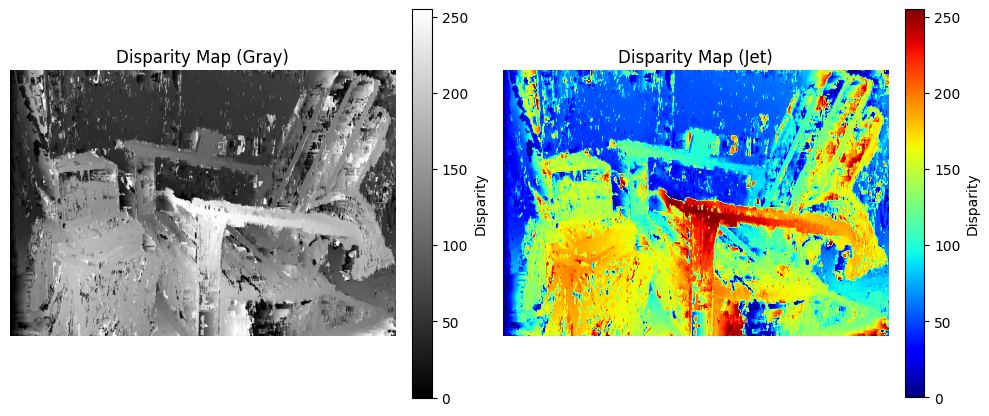

In [58]:
# Load and preprocess images
left_image_path = r"C:/Users/areda/HHU/Computer vision/project 3/Adirondack-perfect/im0.png"
right_image_path = r"C:/Users/areda/HHU/Computer vision/project 3/Adirondack-perfect/im1.png"

left_img = preprocess_image(left_image_path)
right_img = preprocess_image(right_image_path)

max_disparity = 96  # Example value, should be divisible by 16
window_size = 15  # Increased window size for better matching

# Compute disparity using the same block matching approach
disparity_map = compute_disparity(left_img, right_img, max_disparity, window_size)

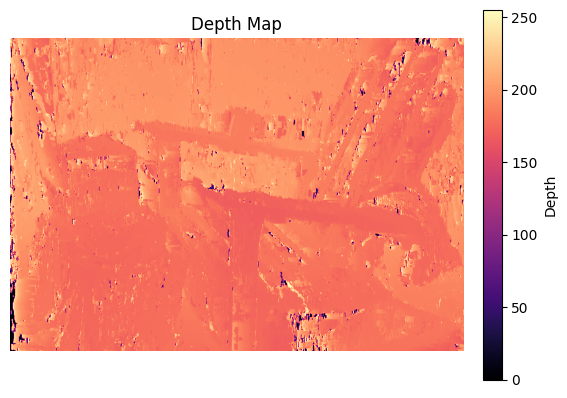

In [128]:
calib_file_path = r"C:/Users/areda/HHU/Computer vision/project 3/Adirondack-perfect/calib.txt"

# Read calibration parameters
focal_length, baseline = read_calibration_parameters(calib_file_path)

# Compute depth map
depth_map = compute_depth(disparity_map, focal_length, baseline)

visualize_depth_map_log(depth_map, title='Depth Map')
plt.show()

### Disparity & Depth Maps for Adirondack-perfect Dataset (with different Exposure):

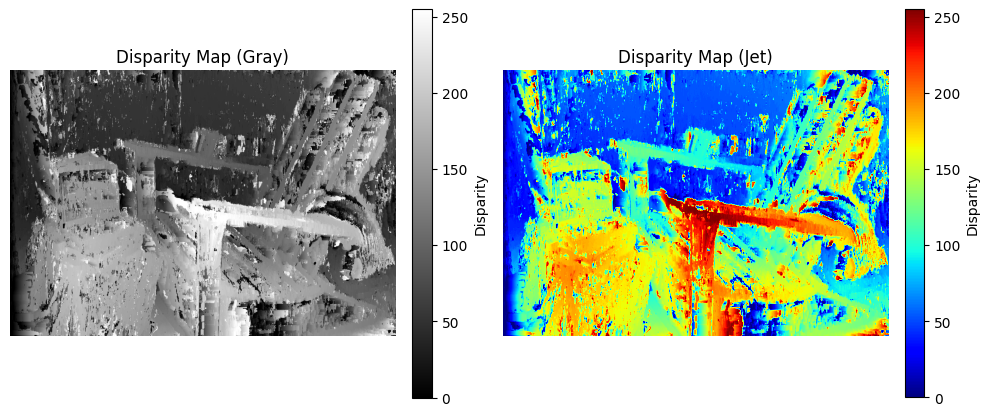

In [30]:
# Load and preprocess images
right_image_E_path = r"C:/Users/areda/HHU/Computer vision/project 3/Adirondack-perfect/im1E.png"
right_img_E = preprocess_image(right_image_E_path)
# Compute disparity using the same block matching approach
disparity_map_E = compute_disparity(left_img, right_img_E, max_disparity, window_size)

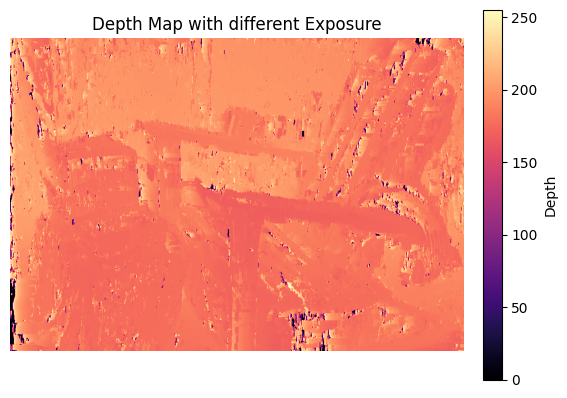

In [127]:
# Compute depth map
depth_map_E = compute_depth(disparity_map_E, focal_length, baseline)

visualize_depth_map_log(depth_map_E, title='Depth Map with different Exposure')
plt.show()

### Disparity & Depth Maps for Adirondack-perfect Dataset (with different Lightning):

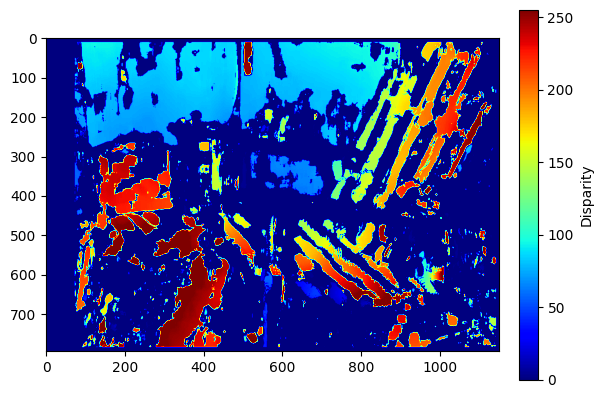

In [83]:
# Load and preprocess images
right_image_L_path = r"C:/Users/areda/HHU/Computer vision/project 3/Adirondack-perfect/im1L.png"
right_img_L = preprocess_image(right_image_L_path)
# Compute disparity using the same block matching approach
#disparity_map_L = compute_disparity(left_img, right_img_L, max_disparity, window_size)

stereo_bm = cv2.StereoBM_create(numDisparities=16*4, blockSize=21)
disparity_map_L = stereo_bm.compute(left_img, right_img_L)

normalized_disparity_L = cv2.normalize(disparity_map_L, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
normalized_disparity_L = np.uint8(normalized_disparity_L)

plt.imshow(normalized_disparity_L, cmap='jet')
plt.colorbar(fraction=0.046, pad=0.04).set_label('Disparity')
plt.show()


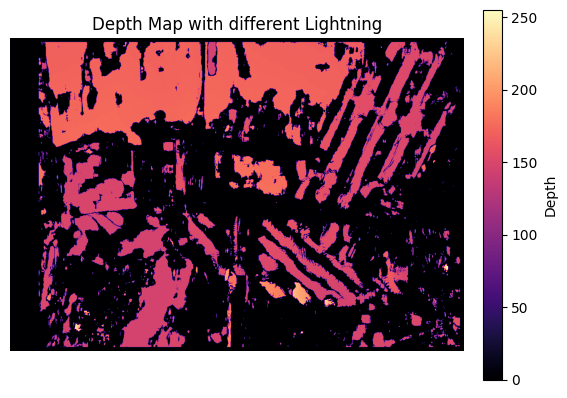

In [126]:
# Compute depth map
depth_map_L = compute_depth(disparity_map_L, focal_length, baseline)

visualize_depth_map_log(depth_map_L, title='Depth Map with different Lightning')
plt.show()

### MRF for disparity map of default images (no variation in lightning or exposure):

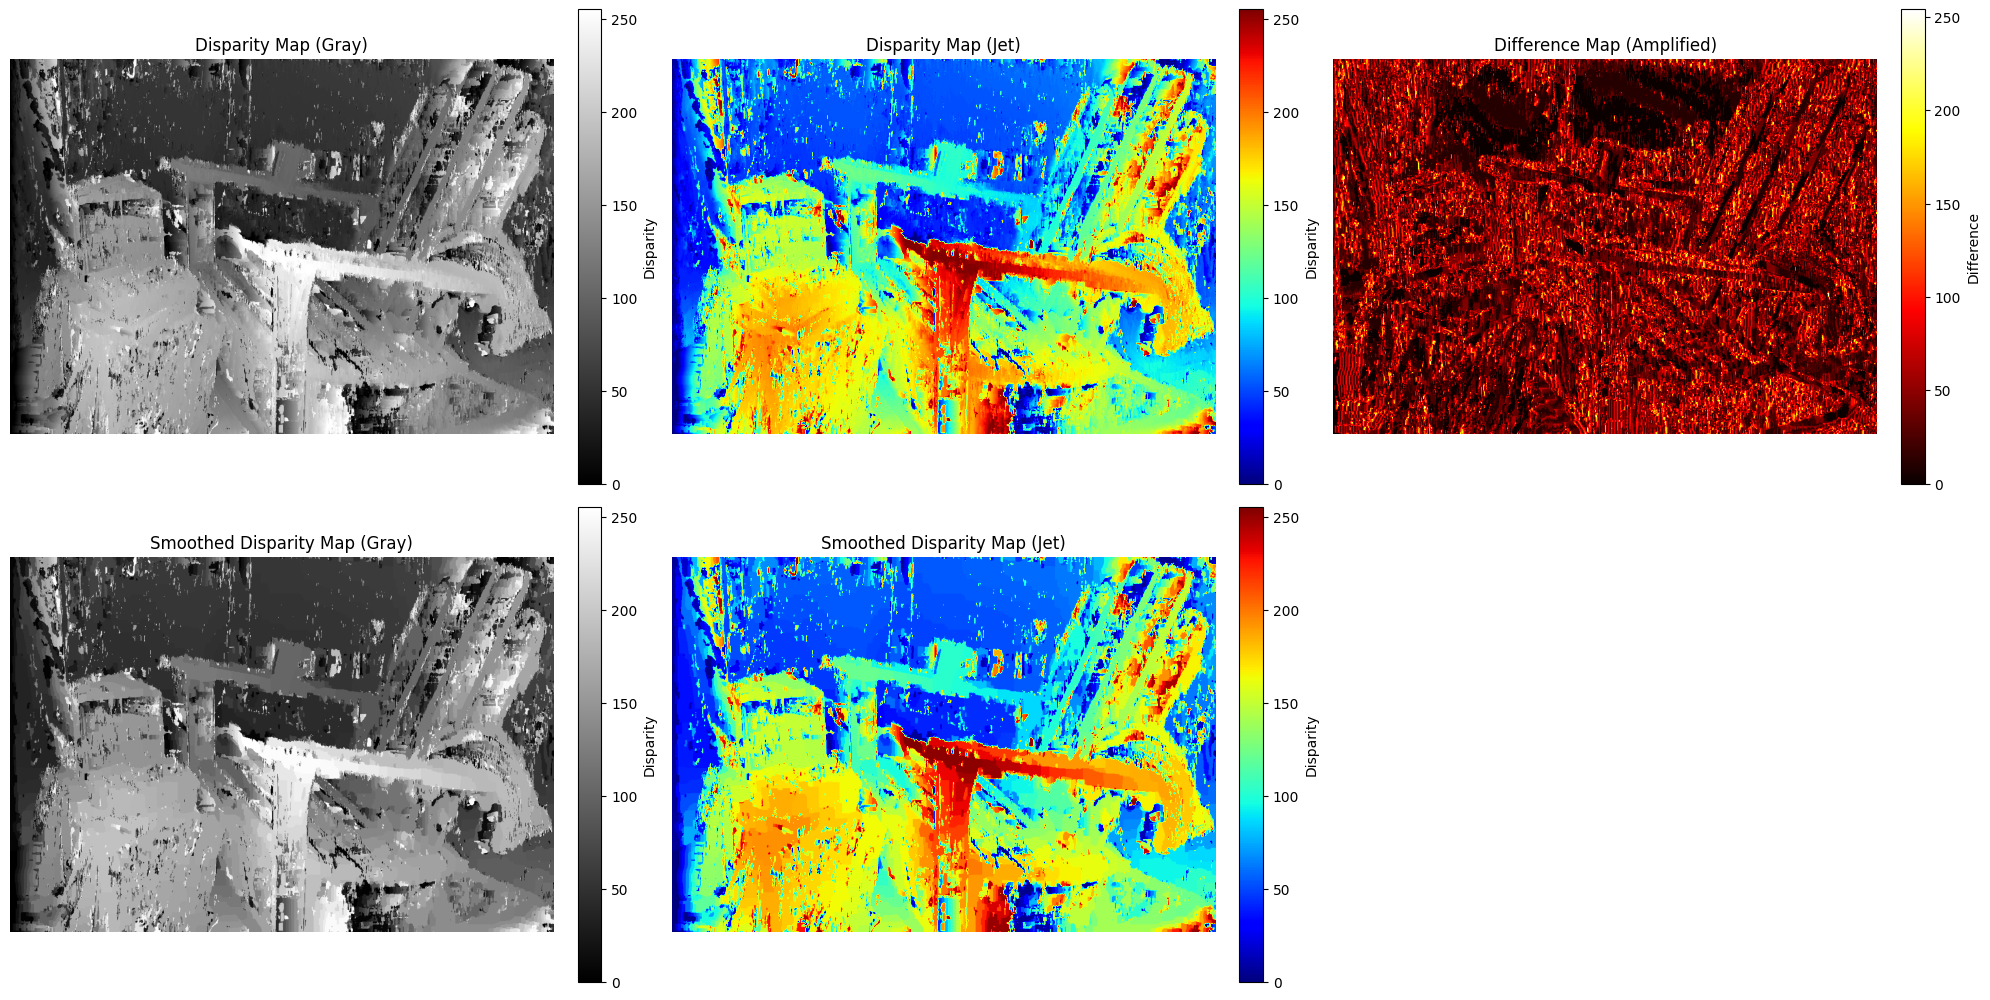

In [11]:
# Apply MRF smoothing
smoothed_disparity = apply_mrf_smoothing(disparity_map, max_disparity)

# Normalize and visualize disparity maps
normalize_and_visualize_disparity_maps(disparity_map, smoothed_disparity)

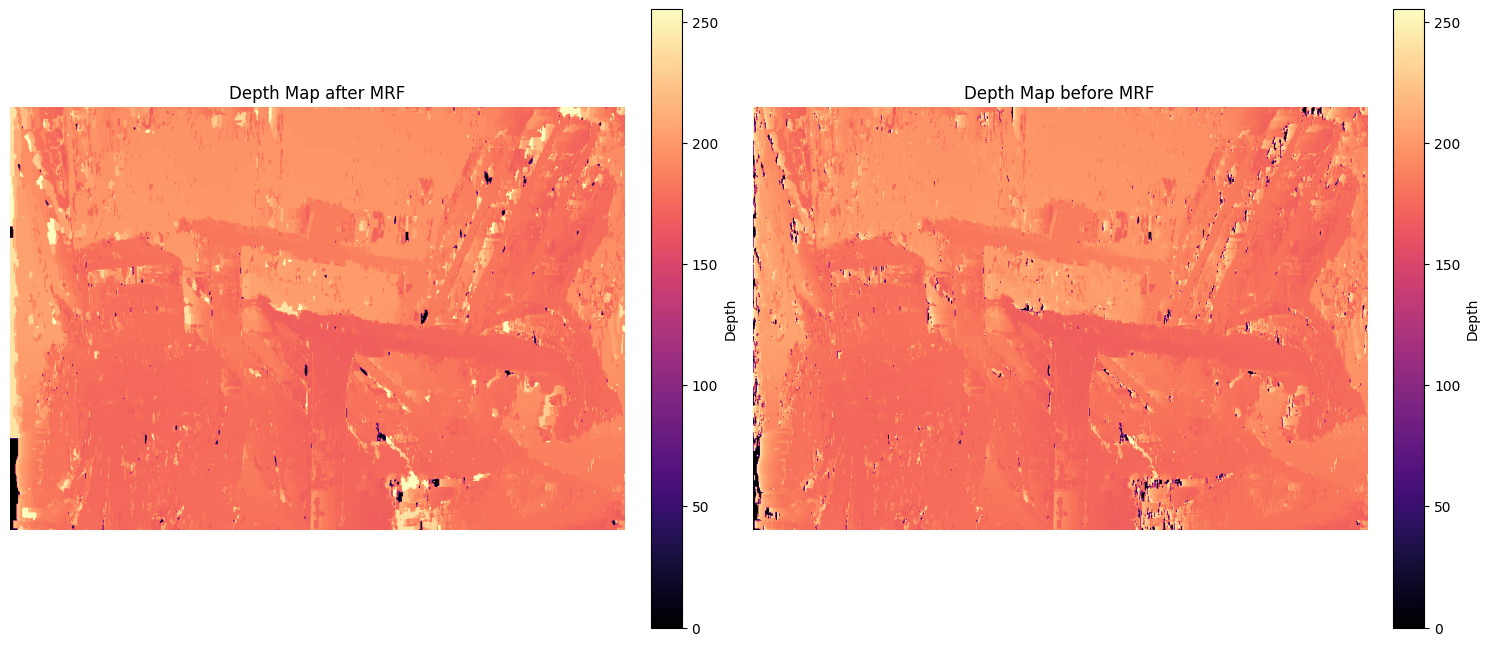

In [125]:
# Compute depth map
depth_map_MRF = compute_depth(smoothed_disparity, focal_length, baseline)

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
visualize_depth_map_log(depth_map_MRF, title='Depth Map after MRF')

plt.subplot(1, 2, 2)
visualize_depth_map_log(depth_map, title='Depth Map before MRF')

plt.tight_layout()
plt.show()

### MRF for disparity map where there is a variation in Exposure:

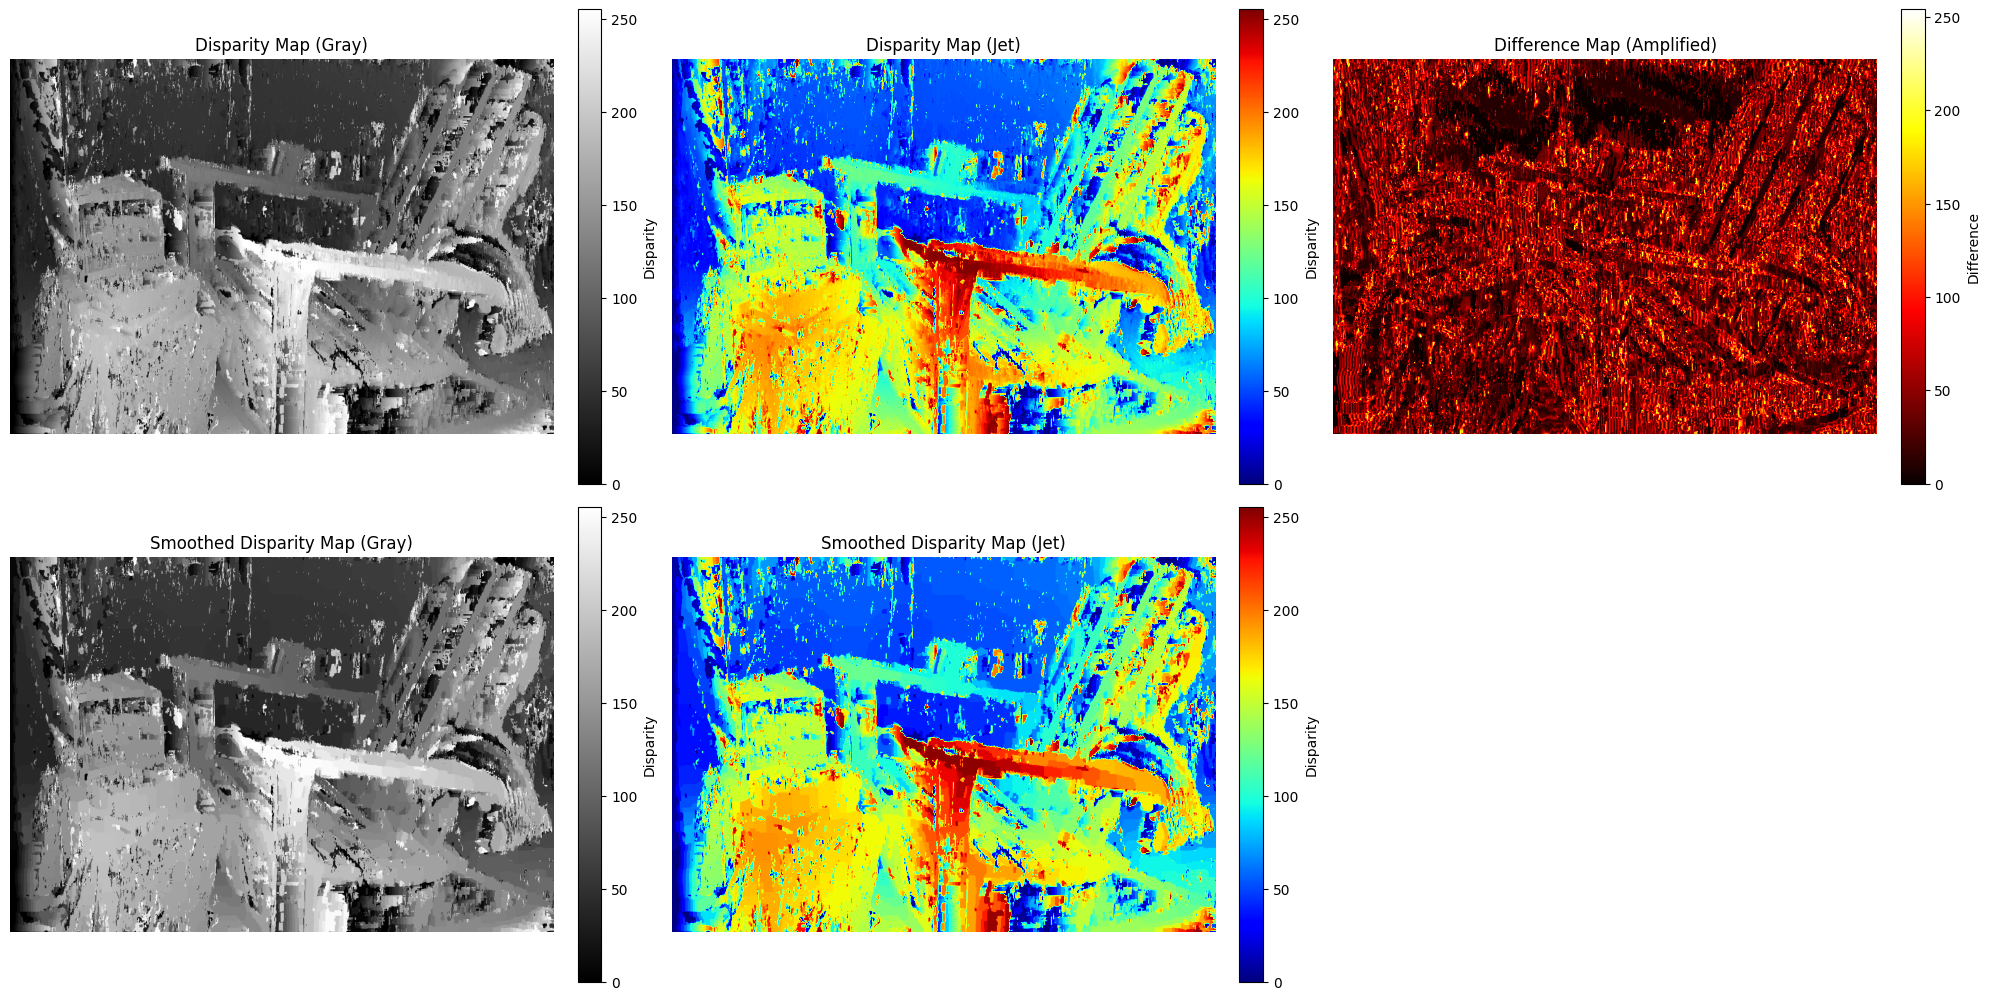

In [87]:
# Apply MRF smoothing
smoothed_disparity_E = apply_mrf_smoothing(disparity_map_E, max_disparity)

# Normalize and visualize disparity maps
normalize_and_visualize_disparity_maps(disparity_map_E, smoothed_disparity_E)

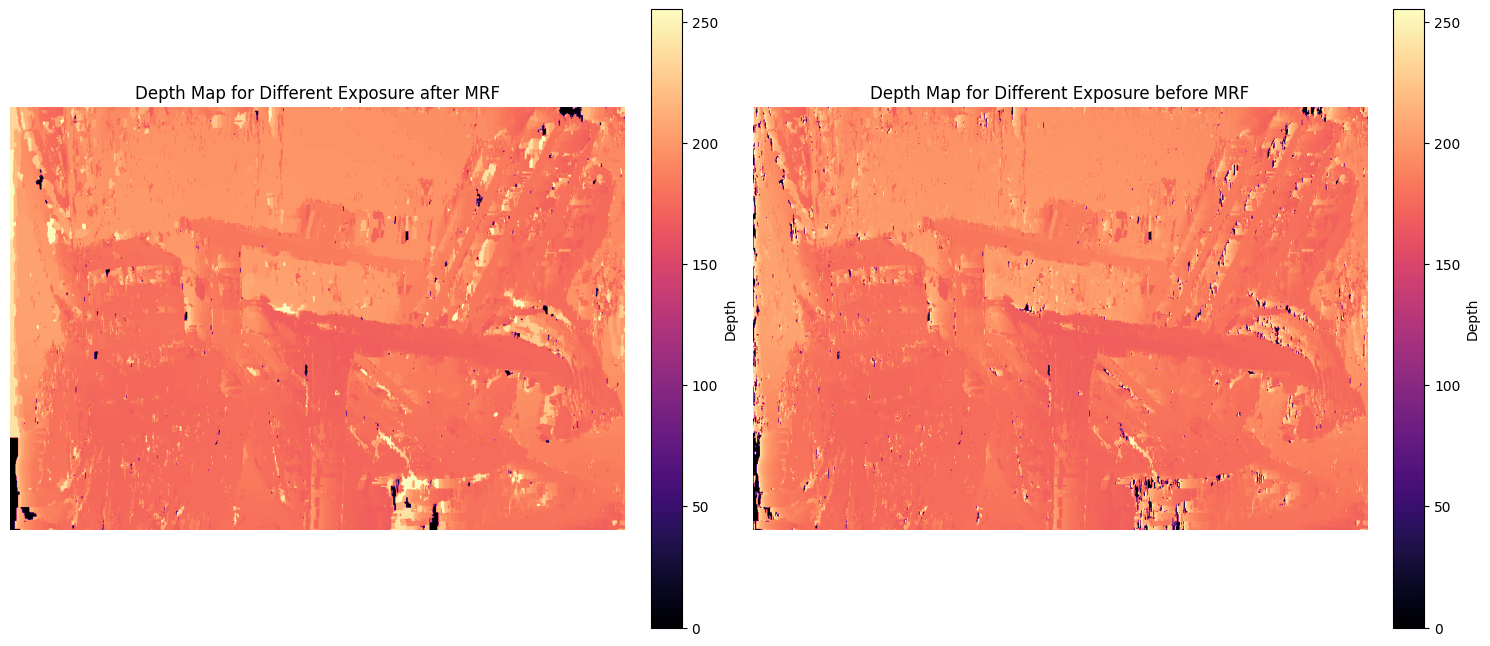

In [123]:
# Compute depth map
depth_map_E_MRF = compute_depth(smoothed_disparity_E, focal_length, baseline)

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
visualize_depth_map_log(depth_map_E_MRF, title='Depth Map for Different Exposure after MRF')

plt.subplot(1, 2, 2)
visualize_depth_map_log(depth_map_E, title='Depth Map for Different Exposure before MRF')

plt.tight_layout()
plt.show()

### MRF for disparity map where there is a variation in Lightning:

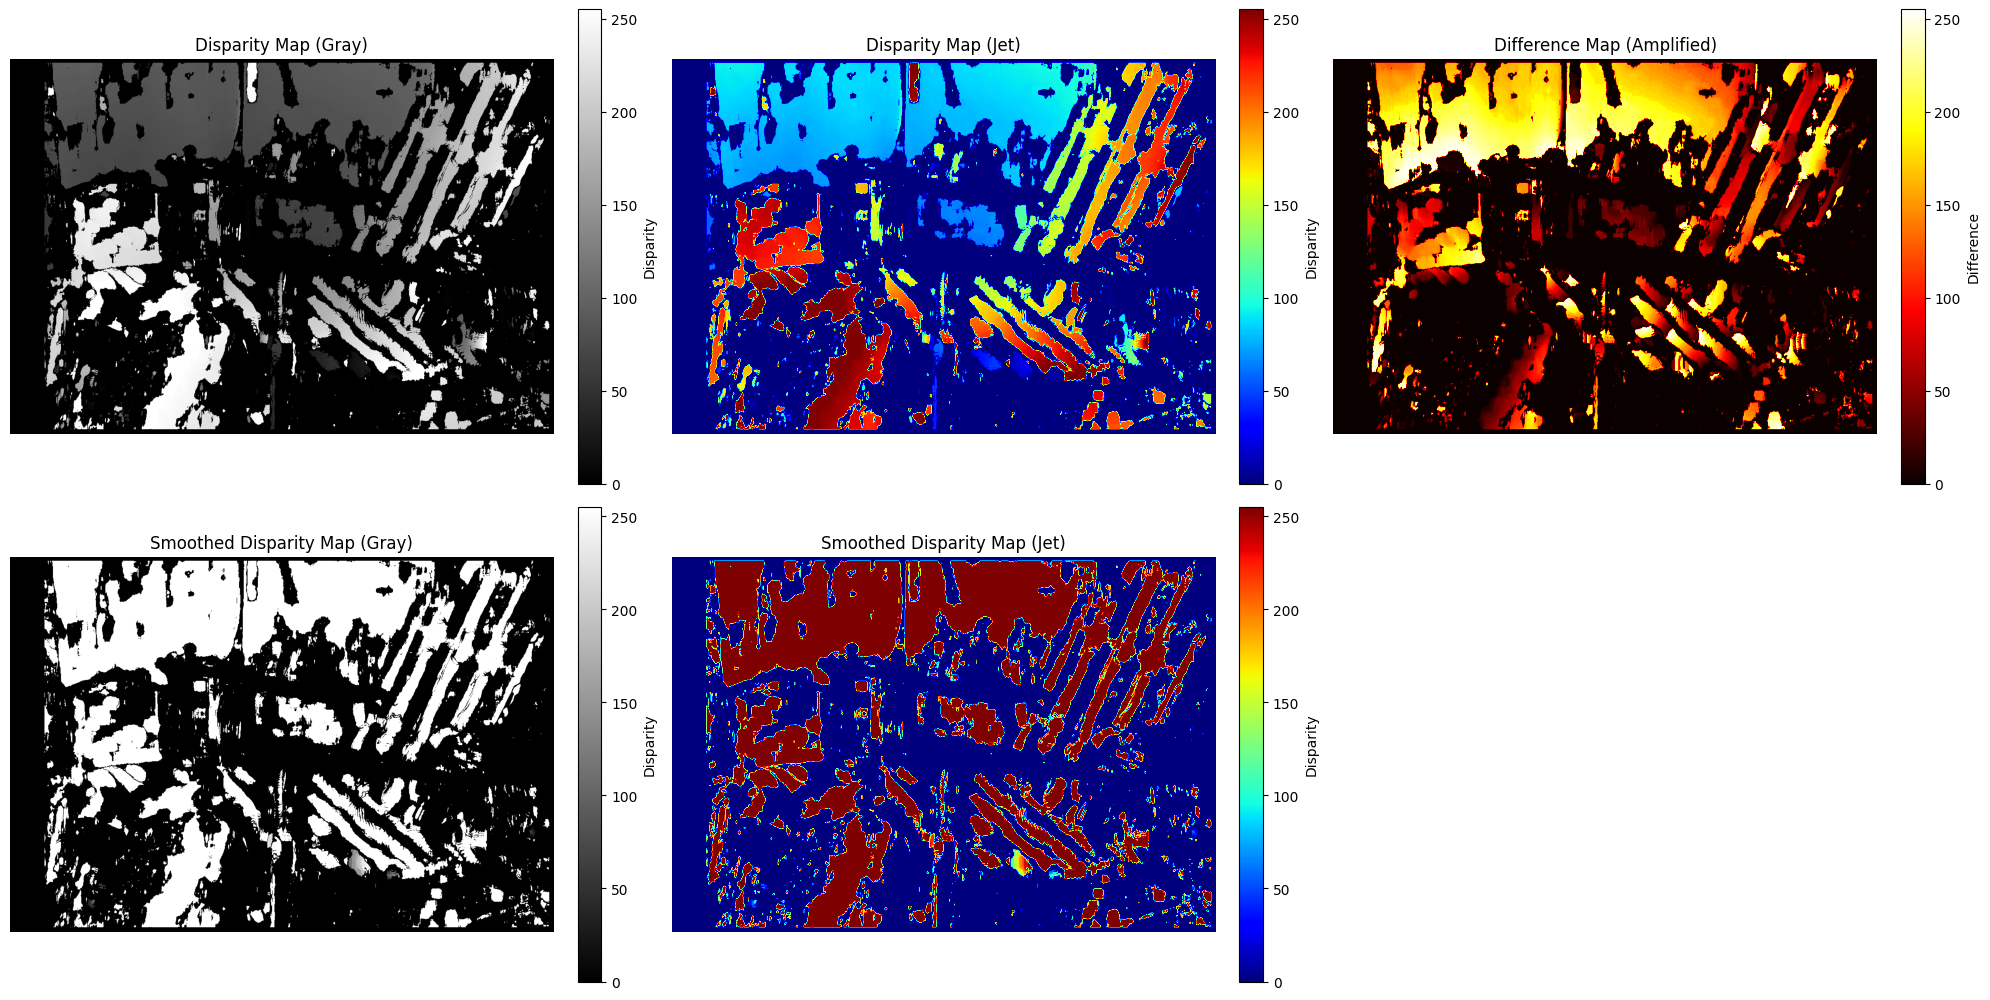

In [89]:
# Apply MRF smoothing
smoothed_disparity_L = apply_mrf_smoothing(disparity_map_L, max_disparity)

# Normalize and visualize disparity maps
normalize_and_visualize_disparity_maps(disparity_map_L, smoothed_disparity_L)

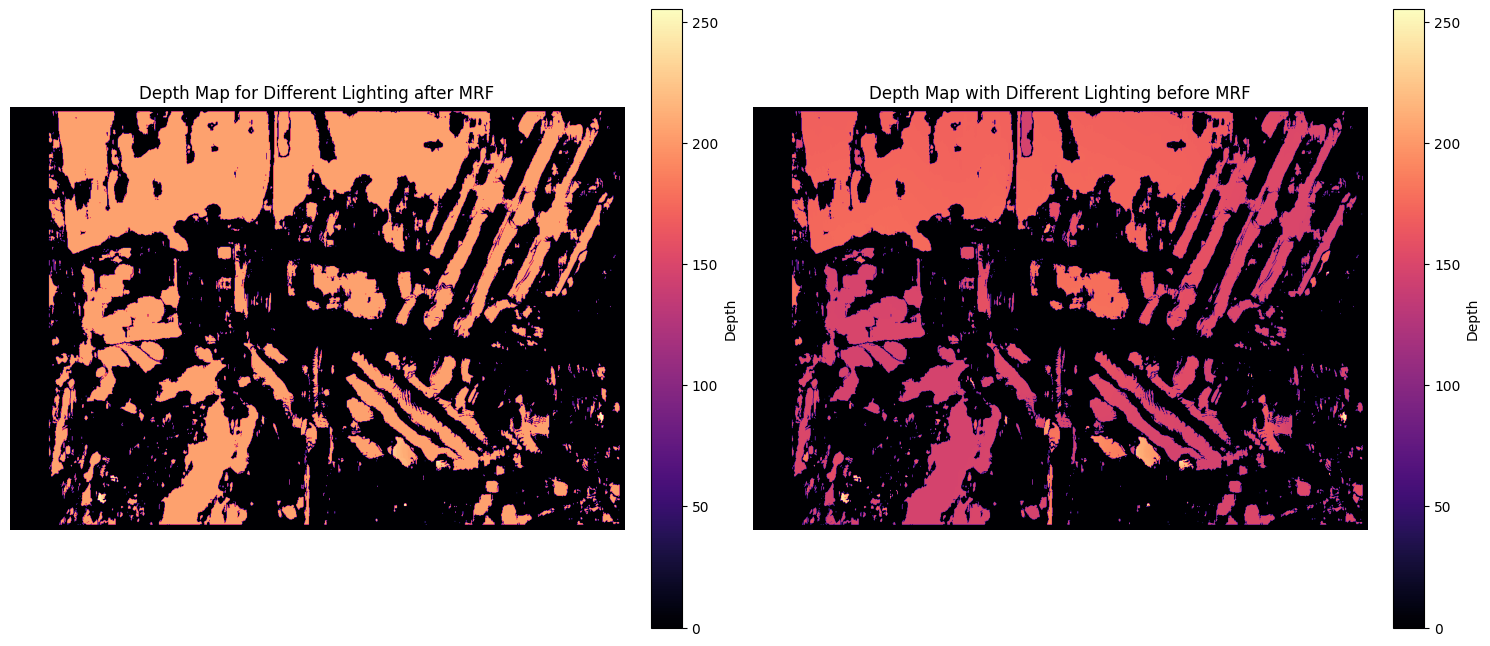

In [124]:
# Compute depth map
depth_map_L_MRF = compute_depth(smoothed_disparity_L, focal_length, baseline)

plt.figure(figsize=(15, 10))

# First subplot
plt.subplot(1, 2, 1)
visualize_depth_map_log(depth_map_L_MRF, title='Depth Map for Different Lighting after MRF')

# Second subplot
plt.subplot(1, 2, 2)
visualize_depth_map_log(depth_map_L, title='Depth Map with Different Lighting before MRF')

plt.tight_layout()
plt.show()